### Trying to encode chaos into images
Pretty basic for now


In [1]:
from pytisean import tiseano, tiseanio
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from scipy import integrate

import seaborn as sns
import matplotlib.image as mpimg

from ipywidgets import interact, interactive
from IPython.display import clear_output, display, HTML
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import cnames
from matplotlib import animation

%matplotlib inline


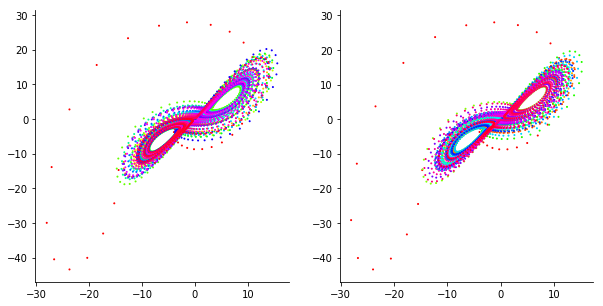

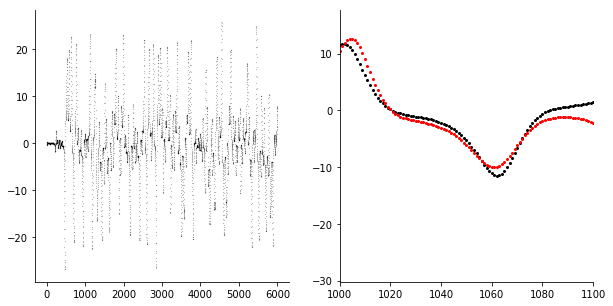

In [6]:
N=2
angle=0.0 
max_time=100.0
sigma=10.0 
beta=4./3 
rho=28.0

def lorenz_deriv(x_y_z, t0, sigma=sigma, beta=beta, rho=rho):
    x, y, z = x_y_z
    return [sigma * (y - x), x * (rho - z) - y, x * y - beta * z]

np.random.seed(1)
x0 = -15 + 30 * np.array([[  0.02,   0.01,   0.002]])
# Solve for the trajectories
t = np.linspace(0, max_time, int(60*max_time))
x_t = np.asarray([integrate.odeint(lorenz_deriv, x0i, t)
                  for x0i in x0])

x, y, z = x_t[0,:,:].T
L1 = pd.DataFrame(dict(X = x, Y = y, Z = z))

np.random.seed(2)
x0 = -15 + 30 * np.array([[  0.01, 0.009, 0.0019]])
# Solve for the trajectories
t = np.linspace(0, max_time, int(60*max_time))
x_t = np.asarray([integrate.odeint(lorenz_deriv, x0i, t)
                  for x0i in x0])

x, y, z = x_t[0,:,:].T
L2 = pd.DataFrame(dict(X2 = x, Y2 = y, Z2 = z))
f, (ax1, ax2) = plt.subplots(1,2,figsize = (10,5))
ax1.scatter(L1.X, L1.Y, c = L1.index, s = 1, cmap='hsv')
ax2.scatter(L2.X2, L2.Y2, c = L2.index, s = 1, cmap='hsv')
sns.despine()

f, (ax1, ax2) = plt.subplots(1,2,figsize = (10,5))
ax1.plot(L1.X - L2.X2, 'ok', markersize = 0.1)
ax2.plot(L1.X, 'ok', markersize = 2)
ax2.plot(L2.X2, 'or', markersize = 2)

ax2.set_xlim([1000, 1100])
sns.despine()

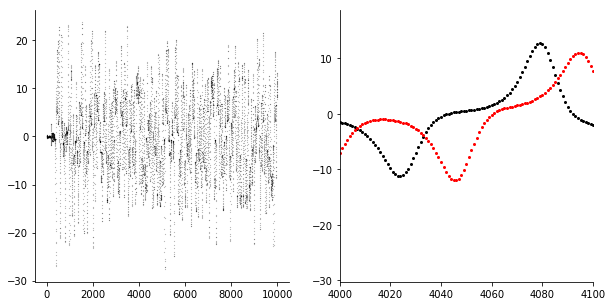

#### First we read in an image and generate a chaotic attractor
Here we had the idea to cheat initially and just create two chaotic series, with slightly offset time intervals.


TISEAN 3.0.1 (C) R. Hegger, H. Kantz, T. Schreiber (1998-2007)

lorenz: integration of the Lorenz system
opened /tmp/pytisean_temp_2019-06-17-13-11-43_1n2cnys2/outFile for output
 Lorenz trajectory covering   128.000000      time units

 Lyapunov exponents [1/unit time]
  0.932167947    
  -2.97854305E-03
  -14.5958557    


TISEAN 3.0.1 (C) R. Hegger, H. Kantz, T. Schreiber (1998-2007)

lorenz: integration of the Lorenz system
opened /tmp/pytisean_temp_2019-06-17-13-11-43_wrjx_x4e/outFile for output
 Lorenz trajectory covering   123.076920      time units

 Lyapunov exponents [1/unit time]
  0.924915969    
  -4.08903230E-03
  -14.4234943    



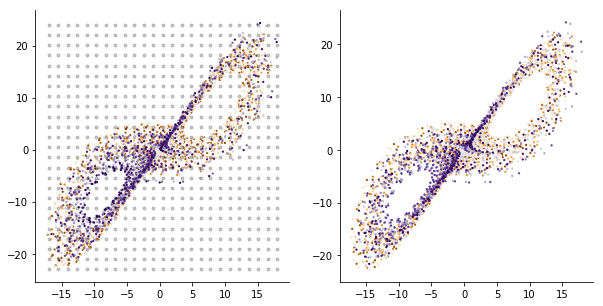

In [4]:
img = mpimg.imread('demo.png')
numPixels = np.size(img[20:60,40:80,0].ravel())
imgMap = pd.DataFrame(dict(Time = np.arange(0,numPixels), 
                  R = img[20:60,40:80,0].ravel(), 
                  G = img[20:60,40:80,1].ravel(), 
                  B = img[20:60,40:80,2].ravel(),
                  A = img[20:60,40:80,3].ravel()))

lorenz, err = tiseano('lorenz', '-l3200', '-f25')
Time = np.arange(0,len(lorenz))
LDF = pd.DataFrame(dict(Time = Time, x=lorenz[:,0], 
                  y = lorenz[:,1], z = lorenz[:,2]))


Time = np.arange(0,len(lorenz))
LDF = pd.DataFrame(dict(Time = Time, x=lorenz[:,0], 
                  y = lorenz[:,1], z = lorenz[:,2]))
lorenz2, err = tiseano('lorenz', '-l3200', '-f26')



Time2 = np.arange(0,len(lorenz2))
LDF2 = pd.DataFrame(dict(Time = Time, x=lorenz2[:,0], 
                  y = lorenz2[:,1], z = lorenz2[:,2]))

#ax.scatter(LDF.x, LDF.y, c = LDF.Time, s = 1.5, cmap='PuOr')

nx, ny = (25, 25)
x = np.linspace(LDF.x.min().round(), LDF.x.max().round(), nx)
y = np.linspace(LDF.y.min().round(), LDF.y.max().round(), ny)
xv, yv = np.meshgrid(x, y)
#xv, yv = np.meshgrid(x, y, sparse=True)  # make sparse output arrays

snip = img[20:60,40:80,0]
f, (ax1, ax2) = plt.subplots(1,2,figsize = (10,5))
ax1.plot(xv.flat,yv.flat,'.k', alpha = 0.2)
ax1.scatter(LDF.x, LDF.y, c = LDF.Time, s = 1.5, cmap='PuOr')
ax2.scatter(LDF2.x, LDF2.y, c = LDF.Time, s = 1.5, cmap='PuOr')

sns.despine()

### This is the meaty bit
where we take a subset of the training image and do the mapping from one series to another. It takes a minute or so to run given the matching algorithm is pretty unoptimized.

In [5]:
imgMap = pd.DataFrame(dict(Time = np.arange(0,numPixels), 
                  IMG = snip.ravel()))
LDF['IMG'] = imgMap.IMG

imgMap = pd.DataFrame(dict(Time = np.arange(0,numPixels), 
                  IMG = snip.ravel()))
LDF['x2'] = LDF2.x
LDF['IMG2'] = np.nan

### Conduct image row by row permutations

In [6]:
for time in LDF.Time:
    x2 = LDF.x2[time]
    x1 = LDF.x[time]
    xdif = np.abs(LDF.x2 - x1)
    xdifArray = pd.DataFrame(dict(XDif = xdif))
    sortedDif = xdifArray.sort_values('XDif').reset_index()
    variation = sortedDif['index'][0]
    LDF.IMG2[time] = LDF.IMG[variation]

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.path while we load stuff.


### Now that the remapping is finshed
we can take a look at the output. We can also run the reshaping in reverse to make sure the garbled output is happening correctly. Its a mess, but its a start.

Next steps are to advance the series properly using an ODE and integrate from slightly different initial conditions. Also, given the series starts to diverge the longer it runs, we can try and do this image noise introduction one line at a time.

### The x-values start to get crazy over time
This makes sense, if we were only using the say first 500 values, we would be in better shape. The line by line idea may help a lot.

### Here'e the full image and some code to cut it up into its colors

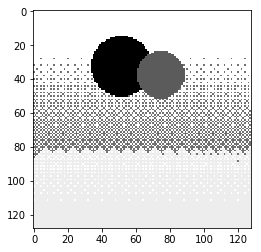

In [70]:
img = mpimg.imread('demo.png')
plt.imshow(img)
numPixels = np.size(img[:,:,0].ravel())
plt.imshow(img[:,:,0], cmap = 'gray')
imgMap = pd.DataFrame(dict(Time = np.arange(0,numPixels), 
                  R = img[:,:,0].ravel(), 
                  G = img[:,:,1].ravel(), 
                  B = img[:,:,2].ravel(),
                  A = img[:,:,3].ravel()))

#pd.concat([LDF, imgMap])
imgMap.index = imgMap.Time
LDF.index = LDF.Time

#imgMap = imgMap.append(imgMap)
#wrapped = pd.concat([LDF,imgMap], axis = 1, ignore_index=True)


In [16]:
wrapped.columns = ['CAidx','x','y','z','A','R','G','B','IMGidx']
wrapped.head()

,CAidx,x,y,z,A,R,G,B,IMGidx
Time,,,,,,,,,
0,0,-3.454,-2.268,23.393,1.0,1.0,1.0,1.0,0.0
1,1,-3.348,-2.411,22.856,1.0,1.0,1.0,1.0,1.0
2,2,-3.266,-2.564,22.336,1.0,1.0,1.0,1.0,2.0
3,3,-3.207,-2.729,21.832,1.0,1.0,1.0,1.0,3.0
4,4,-3.170,-2.906,21.346,1.0,1.0,1.0,1.0,4.0
